# Experiments with Histogram-Based Gradient Boosting


Primary Goals:
- Find a boosting method with magnitudes faster training time
- Evaluate the performance trade-offs (if any) between regular gradient boosting and the histogram-based method
- Alternative method for feature importance estimation: Permutation Importance

**NOTE: This notebook requires scikit-learn >=0.21. Use the "cpac" kernel**:
    
    conda create --name cpac --clone python3
    . /home/ec2-user/anaconda3/etc/profile.d/conda.sh
    conda activate cpac
    conda update --all

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

## Libraries

In [2]:
# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import ensemble, metrics, preprocessing, pipeline, inspection

# Local
import utils

# matplotlib hackery
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,16)

## Load dataset

In [3]:
#dataset_name = "lumbar_results_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (all trials)
dataset_name = "lumbar_results2_PXV_10_15_19.csv" # lab-based target, wearable predictors (subset of trials)
#dataset_name = "lumbar_results3_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (same subset of trials as above)

df_orig = utils.load_dataset("s3://cpac/ORIG/SpinePredictions_500taks_PXV_1S_10_15_19/" + dataset_name)
df_orig.describe()

,Trial_Index_2,Mass_2,Pelvis_Moment_X_2,Pelvis_Moment_Y_2,Pelvis_Moment_Z_2,INSOLE_LFORCE,INSOLE_RFORCE,INSOLE_LXMM,INSOLE_LYMM,INSOLE_RXMM,...,L5S1_Z_1,L4L3_X,L4L3_Y,L4L3_Z,L1T12_X,L1T12_Y,L1T12_Z,T9T8_X,T9T8_Y,T9T8_Z
count,91258.000000,91258.000000,88897.000000,88897.000000,88897.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,...,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000
mean,1498.880295,9.770705,-82.856951,6.221593,-4.552406,482.447499,534.089344,56.976953,106.640490,55.502439,...,-0.115123,-0.123100,0.406183,-5.873359,-0.123059,0.406197,-0.052926,-0.122218,0.292773,5.797092
std,1184.956952,5.183312,73.010224,30.737168,10.377016,291.051994,305.037610,6.372760,48.119794,7.812165,...,5.681981,0.723665,1.043535,2.524663,0.723638,1.043561,2.524660,0.568168,0.764885,1.893398
min,1.000000,5.000000,-383.737732,-1354.738403,-467.997162,7.720000,0.000000,28.170000,33.850000,0.000000,...,-19.151970,-3.288495,-3.861544,-14.354029,-3.288248,-3.861681,-8.533602,-2.638369,-2.874966,-0.564287
25%,463.000000,5.000000,-142.227692,-9.199482,-8.324476,198.991250,269.228250,54.580000,66.020000,51.560000,...,-4.166251,-0.575576,-0.183056,-7.674399,-0.575412,-0.183031,-1.853968,-0.485966,-0.139258,4.446483
50%,1220.000000,10.000000,-65.825653,4.952320,-2.700749,495.001000,526.556000,57.760000,93.960000,57.110000,...,-0.541778,-0.199450,0.358295,-6.060512,-0.199432,0.358302,-0.240079,-0.175457,0.260802,5.656814
75%,2330.000000,15.000000,-15.545347,23.169724,0.239998,732.340250,799.778750,60.430000,144.910000,60.420000,...,4.679438,0.274469,0.997222,-3.745073,0.274424,0.997274,2.075361,0.205431,0.723043,7.393155
max,4765.000000,23.000000,331.114929,1069.714722,907.098022,1239.510000,1331.802000,72.540000,236.040000,76.550000,...,13.951686,3.651306,4.974982,0.367887,3.651238,4.974470,6.188318,2.774458,3.677700,10.477099


## Clean-up dataset

- Associate column types (semi-automatically)
- Eliminate trials start with `"IDP"`
- Eliminate trials containing `"walk"`
- Eliminate samples with missing (`NaN`) values
- Eliminate samples with positive (`>0`) values for Pelvis_Moment_X

In [4]:
def select_solumns(df):
    """Select target and feature columns"""
    META_PATTERNS = [
        "Trial_Name.*",
        "Trial_Index.*",
        "Trial_Type.*",
        "Mass.*"
    ]

    TARGET_PATTERNS = [
        "Pelvis_Moment_X.*",
        "Pelvis_Moment_Y.*",
        "Pelvis_Moment_Z.*"
    ]
    
    meta_names = []
    feature_names = []
    target_names = []
    
    for column in df.columns:
        kind = feature_names
        for pattern in META_PATTERNS:
            if re.match(pattern, column):
                kind = meta_names
        for pattern in TARGET_PATTERNS:
            if re.match(pattern, column):
                kind = target_names
        kind.append(column)

    return target_names, feature_names, meta_names

target_names, feature_names, meta_names = select_solumns(df_orig)
target_name = target_names[0]     # HACK!
#target_name = "Pelvis_Moment_X"
#target_name = "Pelvis_Moment_Y"
#target_name = "Pelvis_Moment_Z"

trial_name = meta_names[0]        # HACK!

df = df_orig.copy()
df = df[~df[trial_name].str.startswith("IDP")]
df = df[~df[trial_name].str.contains("walk")]
df = df.dropna()
df = df[df[target_name] <= 0.0]

print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print("Number of trials:", len(df_orig[trial_name].unique()))

df.describe()

Number of samples: 83653 (before clean-up: 91258)
Number of trials: 49


,Trial_Index_2,Mass_2,Pelvis_Moment_X_2,Pelvis_Moment_Y_2,Pelvis_Moment_Z_2,INSOLE_LFORCE,INSOLE_RFORCE,INSOLE_LXMM,INSOLE_LYMM,INSOLE_RXMM,...,L5S1_Z_1,L4L3_X,L4L3_Y,L4L3_Z,L1T12_X,L1T12_Y,L1T12_Z,T9T8_X,T9T8_Y,T9T8_Z
count,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,...,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000
mean,1543.996414,9.639200,-86.818507,6.486598,-4.764872,482.725898,535.148331,57.029114,107.733197,55.403848,...,0.088452,-0.089115,0.392875,-5.783179,-0.089075,0.392884,0.037252,-0.095659,0.285418,5.864696
std,1176.134709,5.044433,71.449704,30.613124,10.349447,296.476161,310.269712,6.461098,48.400359,7.929074,...,5.674269,0.718334,1.028258,2.521548,0.718305,1.028281,2.521547,0.563176,0.754029,1.891063
min,1.000000,5.000000,-383.737732,-504.596527,-467.997162,7.720000,0.000000,28.170000,35.210000,0.000000,...,-19.151970,-2.295476,-3.861544,-14.354029,-2.295549,-3.861681,-8.533602,-1.771676,-2.874966,-0.564287
25%,518.000000,5.000000,-144.605347,-9.968402,-8.665667,187.553000,254.163000,54.530000,66.120000,51.280000,...,-3.955234,-0.557346,-0.194438,-7.579974,-0.557306,-0.194515,-1.759542,-0.471664,-0.144257,4.516984
50%,1289.000000,10.000000,-72.353416,5.355928,-2.946156,494.930000,531.758000,57.860000,95.910000,57.070000,...,-0.232141,-0.181863,0.358785,-5.921799,-0.181826,0.358795,-0.101364,-0.160972,0.262193,5.760069
75%,2373.000000,15.000000,-19.072489,24.666170,0.127620,744.117000,807.393000,60.560000,147.180000,60.460000,...,4.910700,0.311246,0.985352,-3.642003,0.311232,0.985374,2.178428,0.237134,0.716195,7.470721
max,4765.000000,23.000000,-0.000725,1069.714722,907.098022,1192.645000,1286.620000,72.540000,236.040000,75.010000,...,13.951686,3.651306,4.974982,0.367887,3.651238,4.974470,6.188318,2.774458,3.677700,10.477099


## Train / test partitioning

- Test set: exercises with 5kg weight
- ~~Test set: all samples where `Trial_Name` contains `"freestyle"` (case insensitive)~~
- Train set: all other samples

In [5]:
test_selector = df[trial_name].str.match("S0[0-9]_5kg")
#test_selector = df["Trial_Name"].str.contains("freestyle", case=False)
df_test = df[test_selector]
df_train = df[~test_selector]
print(f"Train set size: {len(df_train)}\nTest set size: {len(df_test)} ({len(df_test) / len(df):.1%})")

Train set size: 71010
Test set size: 12643 (15.1%)


## Train boosted tree models and measure training time

In [6]:
%%time
gb_model = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('gboost', ensemble.GradientBoostingRegressor(n_estimators=200))
])
gb_model.fit(df_train[feature_names], df_train[target_name]);

CPU times: user 2min 45s, sys: 4.2 ms, total: 2min 45s
Wall time: 2min 45s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gboost',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=200,
                                           n_iter_no_change=None,
                      

In [7]:
%%time
hgb_model = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('gboost', ensemble.HistGradientBoostingRegressor(max_iter=200))
])
hgb_model.fit(df_train[feature_names], df_train[target_name]);

CPU times: user 1min 6s, sys: 4.21 s, total: 1min 11s
Wall time: 2.27 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gboost',
                 HistGradientBoostingRegressor(l2_regularization=0.0,
                                               learning_rate=0.1,
                                               loss='least_squares',
                                               max_bins=255, max_depth=None,
                                               max_iter=200, max_leaf_nodes=31,
                                               min_samples_leaf=20,
                                               n_iter_no_change=None,
                                               random_state=None, scoring=None,
                                               tol=1e-07,
                                               validation_fraction=0.1,
                                               verbose=0, warm_start=False))],
         verbose=False)

## Evaluate models


Gradient Boosting:
MSE: 386.00
RMSE: 19.65
R^2 Score: 0.896

Histogram-based Gradient Boosting:
MSE: 385.00
RMSE: 19.62
R^2 Score: 0.898


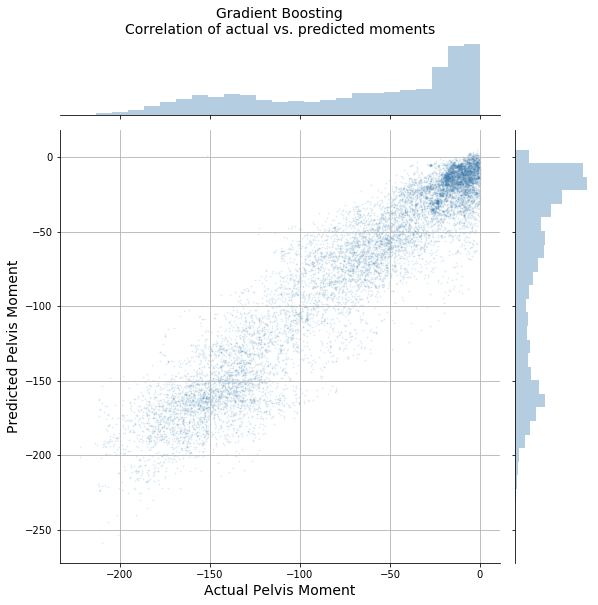

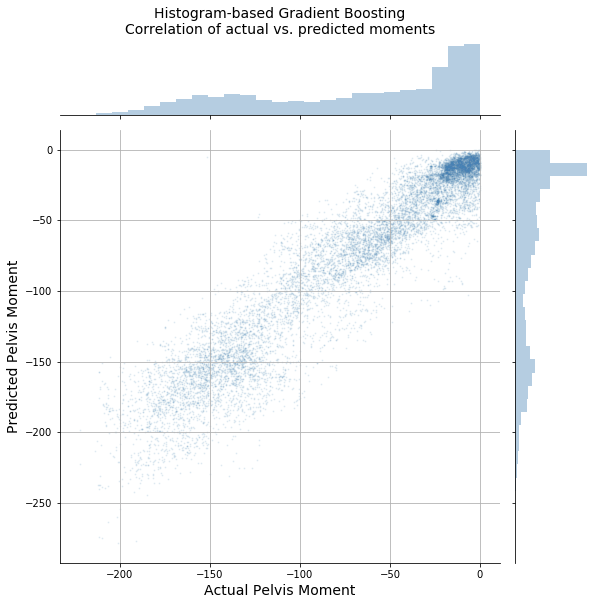

In [8]:
def evaluate_model(title, model, X_test, y_test):
    
    print(f"\n{title}:")
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    mse = metrics.mean_squared_error(y_test_pred, y_test)
    r2 = metrics.r2_score(y_test_pred, y_test)
    print(f"MSE: {mse:.2f}\nRMSE: {np.sqrt(mse):.2f}\nR^2 Score: {r2:.3f}")
    
    # Correlation plot: actual vs. predicted
    ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
    #sns.jointplot(y_test, y_test_pred, kind="hex")
    #sns.jointplot(y_test, y_test_pred, kind="reg")
    ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
    #ax.ax_joint.legend_.remove()
    ax.ax_joint.grid()
    ax.ax_marg_x.set_title(f"{title}\nCorrelation of actual vs. predicted moments", fontsize=14)
    

evaluate_model("Gradient Boosting",
               gb_model, df_test[feature_names], df_test[target_name])

evaluate_model("Histogram-based Gradient Boosting",
               hgb_model, df_test[feature_names], df_test[target_name])    

## Feature importances

Alternatives:
- Random Forest Feature Importance: Mean Decrease in Impurity (MDI)
- Permutation Importance

The potential problems with MDI:
- Impurity-based importances are biased towards high cardinality features
- Impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).
- Not available for the histogram-based boosted trees (scikit-learn does not support this)

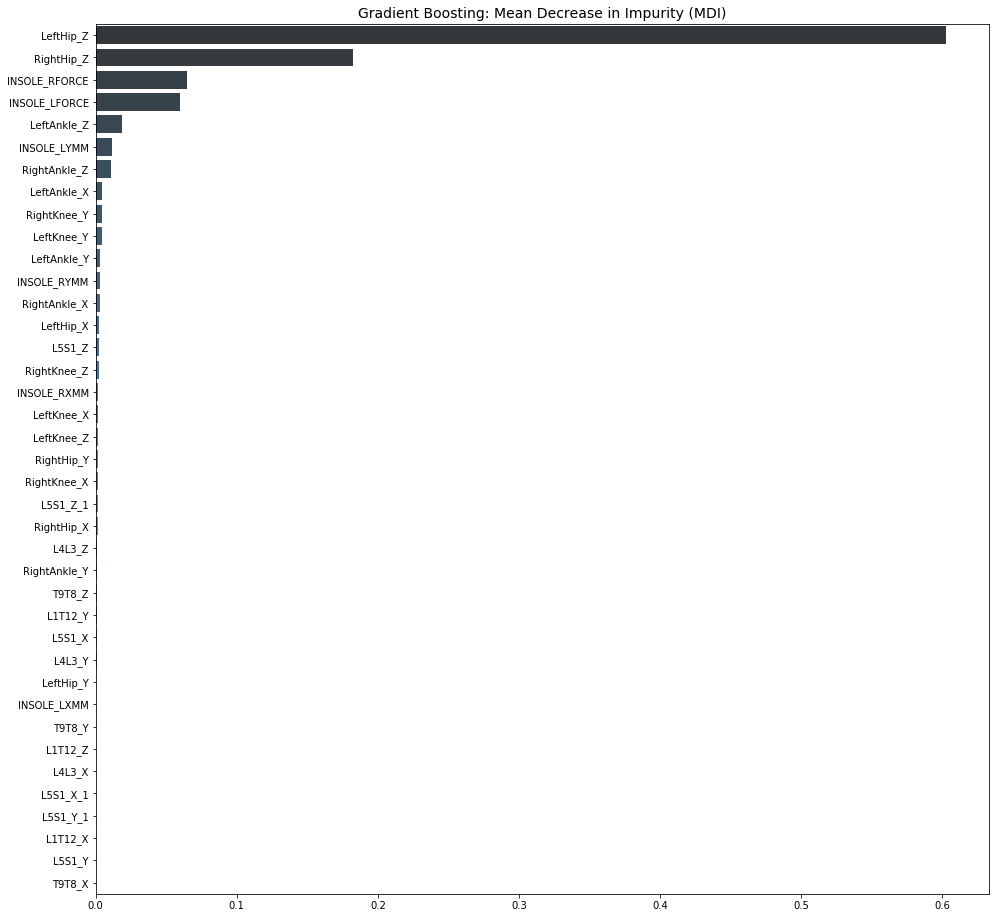

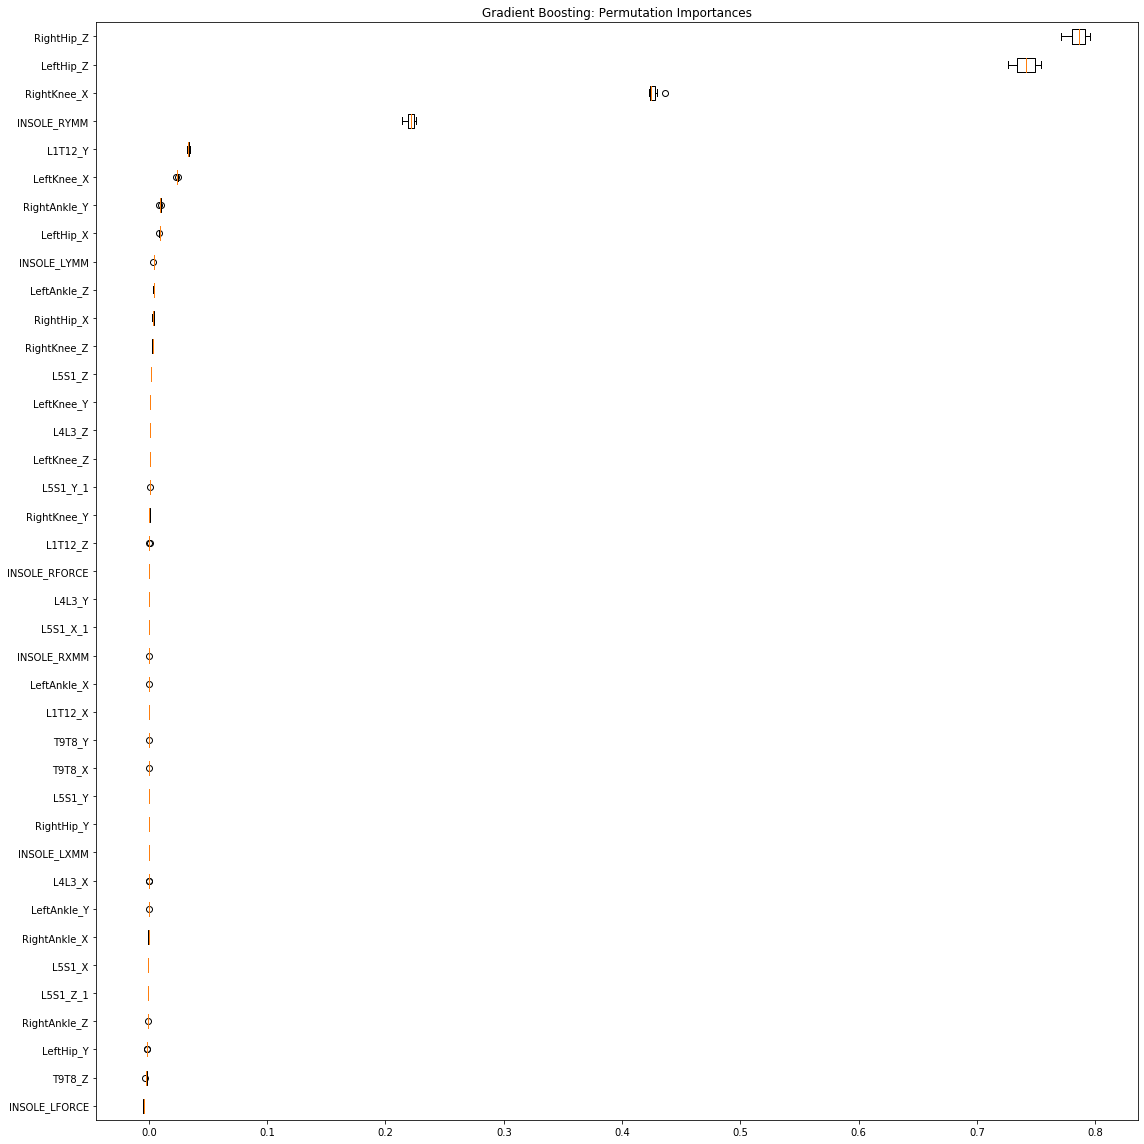

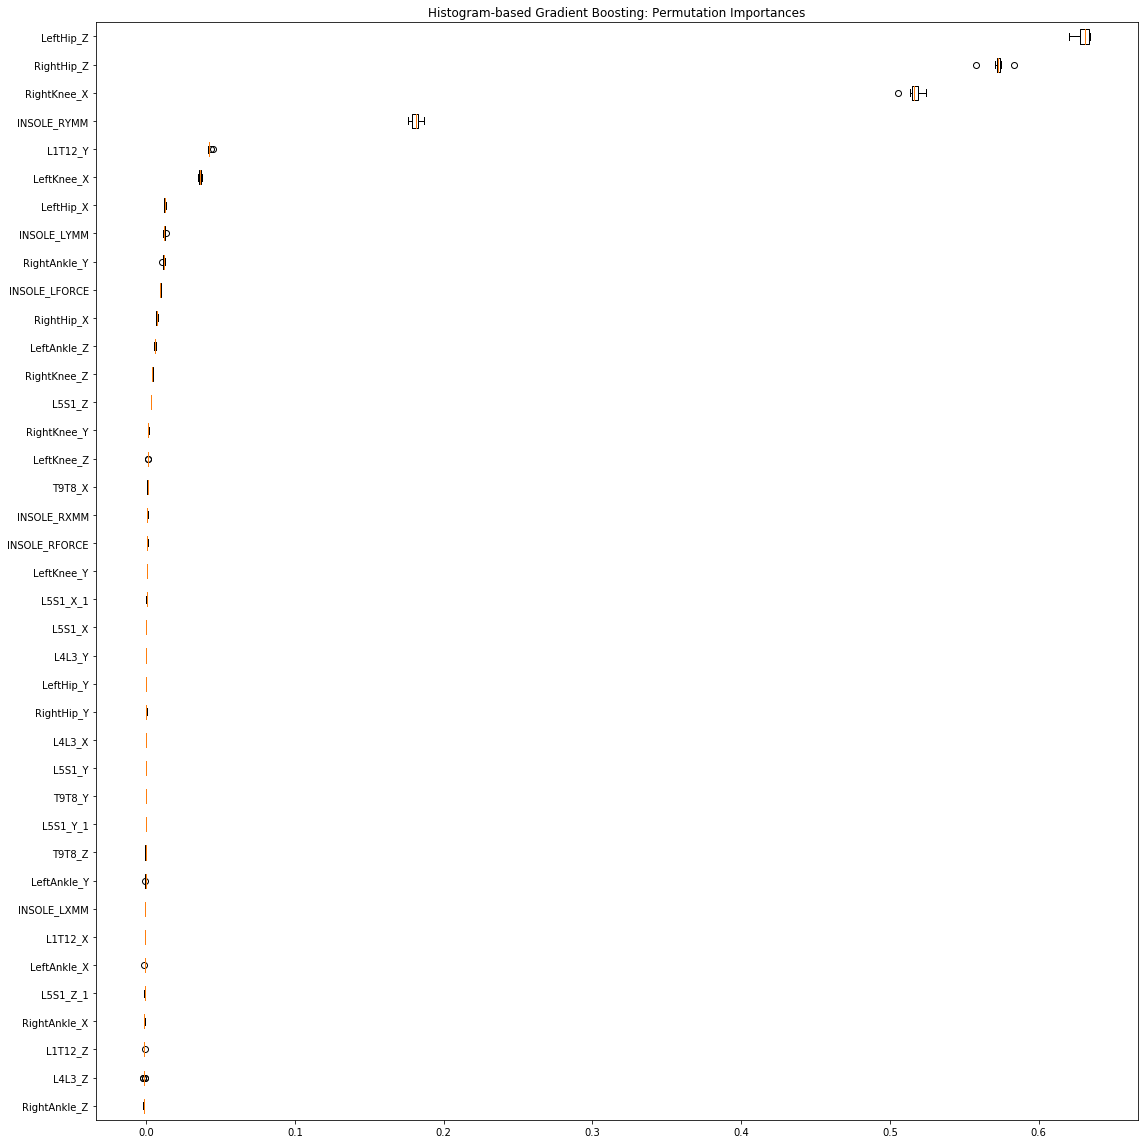

In [9]:
feature_importances = pd.Series(gb_model.named_steps.gboost.feature_importances_, index=feature_names).sort_values(ascending=False)
ax = sns.barplot(y=feature_importances.index, x=feature_importances, palette="Blues_d")
ax.set_title("Gradient Boosting: Mean Decrease in Impurity (MDI)", fontsize=14);


permutation_result = inspection.permutation_importance(gb_model, 
                                           df_test[feature_names], 
                                           df_test[target_name], 
                                           n_repeats=10, n_jobs=-1)
sorted_idx = permutation_result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(permutation_result.importances[sorted_idx].T,
           vert=False, labels=feature_importances.index[sorted_idx])
ax.set_title("Gradient Boosting: Permutation Importances")
fig.tight_layout()
plt.show()

permutation_result = inspection.permutation_importance(hgb_model, 
                                           df_test[feature_names], 
                                           df_test[target_name], 
                                           n_repeats=10, n_jobs=-1)
sorted_idx = permutation_result.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(permutation_result.importances[sorted_idx].T,
           vert=False, labels=feature_importances.index[sorted_idx])
ax.set_title("Histogram-based Gradient Boosting: Permutation Importances")
fig.tight_layout()
plt.show()

